# **SEIR** model of COVID pandemic
Susceptible - Exposed - Infected - Removed

Unit of time is 1 day

Major Unknowns:
* Secondary Attack Rate
* Unaccounted cases
* Contact rates
* Effect of control measures on contact rates

Minor Unknowns:
* Incubation period
* Infection period
* Recovery period

In [1]:
from matplotlib import pyplot as plt
import numpy as np

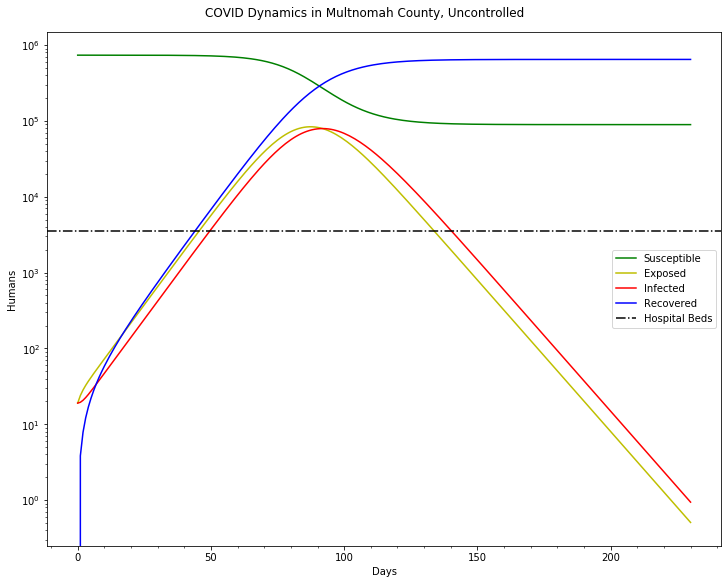

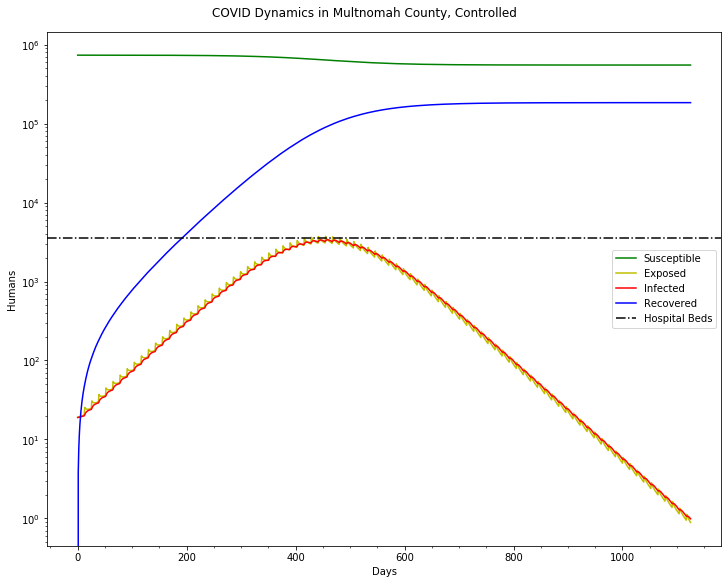

In [13]:
num_days = 125*4
dt = 1. # days per time-step, pls don't adjust for now

population = 735334
exposed = 19
infected = 19

error = 10/100 # percentage of exposed/infected that are unaccounted 

incubation_period = 5 # days, = 1/alpha
infection_period = 5 # days, = 1/gamma
init_R0 = 2.4
attack_rate = .03#0.0048 # close contact secondary attack rate
beds = 3554 # per wikipedia pages, beds licensed in multnomah county hospitals

print_prtb = False
control = False
off_contact_rate = 16
on_contact_rate = 7
start_cycle = 0
days_on = 12
days_off = 1
feedback = False
switch = 100

def Jacobian(state, parameters):
    S = state[0]
    E = state[1]
    I = state[2]
    R = state[3]
    N = S + E + I + R
    
    alpha = parameters[0]
    beta_N = parameters[1]/N
    gamma = parameters[2]
    
    
    DF = np.array([[-beta_N * I, 0, -beta_N * S, 0],
                   [beta_N * I, -alpha, beta_N * S, 0],
                   [0, alpha, -gamma, 0],
                   [0, 0, gamma, 0]])
    return DF



def ODE(state, parameters, perturbation, bang_on):
    S = state[0]
    E = state[1]
    I = state[2]
    R = state[3]
    N = S + E + I + R
    
    #bang_on = -np.log10(I/N) < switch if feedback else bang_on
    bang_on = parameters[1] * (I / N) * S > switch if feedback else bang_on
    contact_rate = on_contact_rate if bang_on else off_contact_rate
    beta_c = attack_rate * contact_rate
    
    alpha = parameters[0]
    beta = parameters[1] if not control else beta_c
    gamma = parameters[2]
    
    T_SE = beta * (I / N) * S
    T_EI = alpha * E
    T_IR = gamma * I
    
    Sdot = - T_SE
    Edot = T_SE - T_EI
    Idot = T_EI - T_IR
    Rdot = T_IR
    
    DF = Jacobian(state, [alpha, beta, gamma])
    Pdot = DF.dot(perturbation)
    
    return np.array([Sdot, Edot, Idot, Rdot]), Pdot, beta/gamma

def runge_kutta(state, parameters, perturbation, dt, state_list, prtb_list, R0_list, bang_on):
    k1, p1, R0_1 = ODE(state, parameters, perturbation,bang_on)
    
    k2, p2, R0_2 = ODE(state + k1*dt/2, parameters, perturbation + p1*dt/2,bang_on)
    
    k3, p3, R0_3 = ODE(state + k2*dt/2, parameters, perturbation + p2*dt/2,bang_on)
    
    k4, p4, R0_4 = ODE(state + k3*dt, parameters, perturbation + p3*dt,bang_on)
    
    new_state = state + dt * (k1 + 2*k2 + 2*k3 + k4)/6
    new_prtb = perturbation + dt * (p1 + 2*p2 + 2*p3 + p4)/6
    #R0 = (R0_1 + 2*R0_2 + 2*R0_3 + R0_4)/6
    R0 = R0_1
    state_list.append(new_state)
    prtb_list.append(new_prtb)
    R0_list.append(R0)

def integration():
    state_list, prtb_list, R0_list = [], [], []
    n = 0
    parameters = [1/incubation_period, init_R0/infection_period, 1/infection_period]
    initial_state = np.array([population - exposed - infected, exposed, infected, 0])
    initial_perturbation = np.array([[0, 0, 0, 0],
                                     [0, exposed*error, 0, 0],
                                     [0, 0, infected*error, 0],
                                     [0, 0, 0, 0]])
    state_list.append(initial_state)
    prtb_list.append(initial_perturbation)
    R0_list.append(init_R0)
    #while len(state_list) < num_days/dt:
    while state_list[-1][2] > 1:
        n += 1
        bang_on = n <= (days_on+start_cycle)/dt
        if n == (days_on+days_off+start_cycle)/dt: n=start_cycle/dt
        runge_kutta(state_list[-1], parameters, prtb_list[-1], dt, state_list, prtb_list, R0_list, bang_on)
        
    
    return state_list, prtb_list, R0_list

def run_sim():
    states, perturbations, R0s = integration()
    total_variations = [np.array([sum(row) for row in prtb]) for prtb in perturbations]
    return states, total_variations, R0s

def graph_sol(states, total_variations, R0s, mode):
    total = [states[i] + prtb for i,prtb in enumerate(total_variations)]

    fig, axis = plt.subplots(constrained_layout=True,figsize=(10, 8))
    axis.set_prop_cycle(color=['g','y','r','b'])

    axis.plot(states)
    if print_prtb: axis.plot(total, '--')

    plt.xlabel('Days')
    plt.ylabel('Humans')
    plt.suptitle('COVID Dynamics in Multnomah County, '+mode)
    plt.minorticks_on()
    #plt.xticks(np.arange(0, num_days/dt, step=8/dt))
    #plt.yticks(np.arange(0, population, step=50000))
    plt.axhline(y=beds, c='black', ls='-.')
    plt.legend(['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Hospital Beds'])
    plt.semilogy()
    plt.show()
    #fig2, axis2 = plt.subplots()
    #axis2.plot(R0s)
    #plt.xlabel('Days')
    #plt.ylabel('R0')
    #plt.show()

states, total_variations, R0s = run_sim()
graph_sol(states, total_variations, R0s, 'Uncontrolled')
control = True
states, total_variations, R0s = run_sim()
graph_sol(states, total_variations, R0s, 'Controlled')

* Hospital beds: 3554, beds licensed in Multnomah county hospitals per Wikipedia pages
* Initial infected: 19, per Oregon Health Authority
* Initial exposed: presumed 19
* Incubation period: 5 days, per WHO-China Joint Mission
* Infective period: 5 days, guess
* R0: 2.4, per WHO-China Joint Mission
* Secondary attack rate: 3%. I've seen conflicting reports, this is a guess.

By relating R0 with secondary attack rate, I've come to the assumption that typically each person contacts 16 others each day.

I assume that during active measures, there are 7 contacts instead.

For the controlled scenario, I assume that there are twelve days "on" for every day "off".

"on" is to be construed as limiting social contact and "off" as normal operations.

This corresponds to an R0 of 1.05 and 2.4 respectively.